In [40]:
pip install git+https://github.com/formll/dog

Looking in indexes: https://pypi.org/simple, http://webservice
  Cloning https://github.com/formll/dog to /tmp/pip-req-build-jq8a9mjx
  Running command git clone --filter=blob:none --quiet https://github.com/formll/dog /tmp/pip-req-build-jq8a9mjx
  Resolved https://github.com/formll/dog to commit 90d70fa511eea5206db051317c3a301d11f3c25d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install git+https://github.com/facebookresearch/dadaptation

Looking in indexes: https://pypi.org/simple, http://webservice
  Cloning https://github.com/facebookresearch/dadaptation to /tmp/pip-req-build-smr9muy9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/dadaptation /tmp/pip-req-build-smr9muy9
  Resolved https://github.com/facebookresearch/dadaptation to commit 665dab09d62f96a1ef6ef8cd3be44de46077a16e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dadaptation: filename=dadaptation-3.1-py3-none-any.whl size=22789 sha256=5599b1252d07d835ae56d28a7efb9bee5ef128a85ac8e3c0a30021a3cc7dabc9
  Stored in directory: /tmp/pip-ephem-wheel-cache-20_s7b85/wheels/d2/7e/1e/7d9b54e1e68fb2389443d862419fe630f7ffce03288777ff8c
Successfully built dadaptation
Note: you may need to restart the kernel to use updated packages.


In [106]:
from dog import DoG
import torch

class DoWG(DoG):
    """
    DoWG algorithm.
    """

    def _update_group_state(self, group, init):
        param_norms = torch.stack([p.norm() for p in group["params"]]).norm()
        grad_sq_norm = torch.stack([(p.grad.detach() ** 2).sum() for p in group["params"]]).sum()
        if self._first_step:
            group["rbar"] = group["reps_rel"] * (1 + param_norms)
            group["G"] = grad_sq_norm * group["rbar"] ** 2 + group["eps"]
        else:
            curr_d = torch.stack([torch.norm(p.detach() - pi) for p, pi in zip(group["params"], init)]).norm()
            group["rbar"] = torch.maximum(group["rbar"], curr_d)
            group["G"] += grad_sq_norm * group["rbar"] ** 2
        group["eta"] = [group["rbar"] ** 2 / torch.sqrt(group["G"])] * len(group["params"])

class TDoWGv1(DoG):
    """
    T-DoWGv1 algorithm.
    """

    def _update_group_state(self, group, init):
        param_norms = torch.stack([p.norm() for p in group["params"]]).norm()
        grad_sq_norm = torch.stack([(p.grad.detach() ** 2).sum() for p in group["params"]]).sum()
        init_G = grad_sq_norm * group["reps_rel"] * (1 + param_norms)
        if self._first_step:
            group["rbar"] = group["reps_rel"] * (1 + param_norms)
            group["G"] = grad_sq_norm * group["rbar"] ** 2 + group["eps"]
            log_term = 1.0
        else:
            curr_d = torch.stack([torch.norm(p.detach() - pi) for p, pi in zip(group["params"], init)]).norm()
            group["rbar"] = torch.maximum(group["rbar"], curr_d)
            group["G"] += grad_sq_norm * (group["rbar"] ** 2)
            log_term = torch.log(group["G"] / init_G) + 1
        group["eta"] = [group["rbar"] ** 2 / (torch.sqrt(group["G"]) * log_term)] * len(group["params"])

class TDoWGv2(DoG):
    """
    T-DoWGv2 algorithm.
    """

    def _update_group_state(self, group, init):
        param_norms = torch.stack([p.norm() for p in group["params"]]).norm()
        grad_sq_norm = torch.stack([(p.grad.detach() ** 2).sum() for p in group["params"]]).sum()
        if self._first_step:
            group["rbar"] = group["reps_rel"] * (1 + param_norms)
            group["G"] = grad_sq_norm * group["rbar"] ** 2 + group["eps"]
            log_term = 1.0
        else:
            curr_d = torch.stack([torch.norm(p.detach() - pi) for p, pi in zip(group["params"], init)]).norm()
            group["rbar"] = torch.maximum(group["rbar"], curr_d)
            log_term = torch.sqrt(torch.log((group["G"] + grad_sq_norm * (group["rbar"] ** 2)) / group["G"]) + 1)
            group["G"] += grad_sq_norm * (group["rbar"] ** 2)
        group["eta"] = [group["rbar"] ** 2 / (torch.sqrt(group["G"]) * log_term)] * len(group["params"])

From PyTorch examples -- MNIST

In [107]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [108]:
def train(log_interval, model, device, train_loader, optimizer, epoch, training_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            training_losses.append(loss.item())


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [126]:
from dadaptation import DAdaptSGD
def trial(alg):
    # Training settings
    use_cuda = True
    use_mps = False

    #torch.manual_seed(32903)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': 1024}
    test_kwargs = {'batch_size': 1024}
    if use_cuda:
        cuda_kwargs = {'num_workers': 16,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net() #.to(device)
    model = nn.DataParallel(model)
    model.to(device)
    
    if alg == "DoWG":
        optimizer = DoWG(model.parameters())
    elif alg == "DoG":
        optimizer = DoG(model.parameters())
    elif alg == "Adam":
        optimizer = optim.Adam(model.parameters())
    elif alg == "DAdaptationSGD":
        optimizer = DAdaptSGD(model.parameters())
    elif alg == "TDoWGv1":
        optimizer = TDoWGv1(model.parameters())
    elif alg == "TDoWGv2":
        optimizer = TDoWGv2(model.parameters())

    scheduler = StepLR(optimizer, step_size=1, gamma=1.0)
    num_epochs = 10
    log_interval = 10
    training_losses = []
    for epoch in range(1, num_epochs + 1):
        train(log_interval, model, device, train_loader, optimizer, epoch, training_losses)
        test(model, device, test_loader)
        scheduler.step()

    torch.save(model.state_dict(), "mnist_cnn.pt")
    return training_losses

In [118]:
import numpy as np

def run_trials(num_trials, alg_name):
    trials = []
    for t in range(num_trials):
        print("TRIAL COUNTER: Running trial {}/{} on {}".format(t+1, num_trials, alg_name))
        trials.append(trial(alg_name))
    return trials

def average_trials(trials):
    return np.mean(trials, axis=0)

def error_trials(trials):
    return np.std(trials, axis=0) / np.sqrt(len(trials))

import matplotlib.pyplot as plt
def plot_training_losses_with_error_bars(train_losses, errors, alg_names, marker_interval=20):
    for (train_loss, error, alg_name) in zip(train_losses, errors, alg_names):
        plt.errorbar(range(len(train_loss)), train_loss, yerr=error, label=alg_name, marker='o', markevery=marker_interval)
    plt.xlabel('Logged Intervals')
    plt.ylabel('Training Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [119]:
num_trials_per_algorithm = 5

In [114]:
trials_dowg = run_trials(num_trials_per_algorithm, "DoWG")

TRIAL COUNTER: Running trial 1/5 on DoWG
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307598
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.308613
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.303991
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.295851
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.104057
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.745292

Test set: Average loss: 1.2045, Accuracy: 5673/10000 (57%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.363312
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.962127
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.671434
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.401622
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.372310


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.284406

Test set: Average loss: 0.1551, Accuracy: 9493/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.260927
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.218985
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.203688
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.179833
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.278390


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.135030

Test set: Average loss: 0.0683, Accuracy: 9783/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.110329
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.128108
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.141327
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.115756
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.117489
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.109626

Test set: Average loss: 0.0547, Accuracy: 9823/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.115763
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.102733
Train Epoch: 5 [20480/60000 (34%)]	Loss: 3.708726
Train Epoch: 5 [30720/60000 (51%)]	Loss: 4.974247
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.861900


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.952420

Test set: Average loss: 0.3068, Accuracy: 9080/10000 (91%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.579533
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.622103
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.355627
Train Epoch: 6 [30720/60000 (51%)]	Loss: 0.321412
Train Epoch: 6 [40960/60000 (68%)]	Loss: 0.267497


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.282800

Test set: Average loss: 0.1141, Accuracy: 9645/10000 (96%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.263554
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.224223
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.203033
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.213663
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.219884


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.177737

Test set: Average loss: 0.0808, Accuracy: 9755/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.166759
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.166770
Train Epoch: 8 [20480/60000 (34%)]	Loss: 0.177113
Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.167060
Train Epoch: 8 [40960/60000 (68%)]	Loss: 0.164801


Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.178759

Test set: Average loss: 0.0656, Accuracy: 9791/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.149946
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.152834
Train Epoch: 9 [20480/60000 (34%)]	Loss: 0.139295
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.161096
Train Epoch: 9 [40960/60000 (68%)]	Loss: 0.176721


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.115755

Test set: Average loss: 0.0518, Accuracy: 9832/10000 (98%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.135497
Train Epoch: 10 [10240/60000 (17%)]	Loss: 0.192817
Train Epoch: 10 [20480/60000 (34%)]	Loss: 0.112194
Train Epoch: 10 [30720/60000 (51%)]	Loss: 0.135572
Train Epoch: 10 [40960/60000 (68%)]	Loss: 0.125884


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.097353

Test set: Average loss: 0.0520, Accuracy: 9844/10000 (98%)

TRIAL COUNTER: Running trial 2/5 on DoWG
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308804
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.302464
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.305722
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.299078
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.206457


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.075835

Test set: Average loss: 1.3371, Accuracy: 5533/10000 (55%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.395597
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.043275
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.515584
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.696082
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.345428


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.317955

Test set: Average loss: 0.2279, Accuracy: 9267/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.350758
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.224089
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.207372
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.383357
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.136036


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.196478

Test set: Average loss: 0.1654, Accuracy: 9499/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.294744
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.406584
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.167037
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.154392
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.134910


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.141349

Test set: Average loss: 0.0966, Accuracy: 9711/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.168775
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.125700
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.081919
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.096462
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.087215


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.094760

Test set: Average loss: 0.0448, Accuracy: 9859/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.089474
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.092574
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.116199
Train Epoch: 6 [30720/60000 (51%)]	Loss: 0.053792
Train Epoch: 6 [40960/60000 (68%)]	Loss: 0.081149


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.102345

Test set: Average loss: 0.0461, Accuracy: 9845/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.066887
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.071928
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.052121
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.147895
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.084975


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.062790

Test set: Average loss: 0.0335, Accuracy: 9890/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.054722
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.058987
Train Epoch: 8 [20480/60000 (34%)]	Loss: 0.069791
Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.060401
Train Epoch: 8 [40960/60000 (68%)]	Loss: 0.085487


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.067243

Test set: Average loss: 0.0376, Accuracy: 9880/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.046222
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.044154
Train Epoch: 9 [20480/60000 (34%)]	Loss: 0.049223
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.061961
Train Epoch: 9 [40960/60000 (68%)]	Loss: 0.037782


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.059513

Test set: Average loss: 0.0489, Accuracy: 9844/10000 (98%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.064036
Train Epoch: 10 [10240/60000 (17%)]	Loss: 0.038134
Train Epoch: 10 [20480/60000 (34%)]	Loss: 0.290089
Train Epoch: 10 [30720/60000 (51%)]	Loss: 1.736904
Train Epoch: 10 [40960/60000 (68%)]	Loss: 1.488182


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.506900

Test set: Average loss: 0.1321, Accuracy: 9590/10000 (96%)

TRIAL COUNTER: Running trial 3/5 on DoWG
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305147
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.303802
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.306285
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.302638
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.082047


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.095656

Test set: Average loss: 1.0336, Accuracy: 6591/10000 (66%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.232657
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.578165
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.664065
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.301410
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.257296


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.184169

Test set: Average loss: 0.1209, Accuracy: 9614/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.189441
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.378407
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.151463
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.151896
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.141769


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.110168

Test set: Average loss: 0.0715, Accuracy: 9778/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.174260
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.091519
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.129763
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.206304
Train Epoch: 4 [40960/60000 (68%)]	Loss: 1.561457


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 4 [51200/60000 (85%)]	Loss: 11.629221

Test set: Average loss: 1.1263, Accuracy: 6225/10000 (62%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.454817
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.738770
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.645706
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.379457
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.340666


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.249507

Test set: Average loss: 0.1233, Accuracy: 9631/10000 (96%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.247061
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.499306
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.211015
Train Epoch: 6 [30720/60000 (51%)]	Loss: 0.182475
Train Epoch: 6 [40960/60000 (68%)]	Loss: 0.152263


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0623042280>
Traceback (most recent call last):
  File "/private/home/akhaled97/mambaforge/envs/opt/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/private/

Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.223942

Test set: Average loss: 0.1092, Accuracy: 9662/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.219027
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.133247
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.211879
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.140718
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.141407
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.130301

Test set: Average loss: 0.0939, Accuracy: 9701/10000 (97%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.190087
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.134699
Train Epoch: 8 [20480/60000 (34%)]	Loss: 0.125674
Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.120747
Train Epoch: 8 [40960/60000 (68%)]	Loss: 0.121561
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.111830

Test set: Average loss: 0.0578, Accuracy: 9800/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.143487
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.120148
Train Epoch: 9 [20480/60000 (34%)]	Loss: 0.088163
Train Epoch: 9 [30720/60000 (51%

Train Epoch: 9 [40960/60000 (68%)]	Loss: 0.170037
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.100617

Test set: Average loss: 0.0577, Accuracy: 9807/10000 (98%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.120495
Train Epoch: 10 [10240/60000 (17%)]	Loss: 0.173818
Train Epoch: 10 [20480/60000 (34%)]	Loss: 0.126864
Train Epoch: 10 [30720/60000 (51%)]	Loss: 0.111051
Train Epoch: 10 [40960/60000 (68%)]	Loss: 0.142375
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.137502

Test set: Average loss: 0.0573, Accuracy: 9819/10000 (98%)



In [115]:
average_train_losses_dowg = average_trials(trials_dowg)
error_trials_dowg = error_trials(trials_dowg)

In [125]:
trials_dog = run_trials(num_trials_per_algorithm, "DoG")

TRIAL COUNTER: Running trial 1/5 on DoG
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308271
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.308370
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.305261
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.304395
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.285917
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.226192

Test set: Average loss: 1.9653, Accuracy: 7379/10000 (74%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.994904
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.791185
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.970699
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.592932
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.609994
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.531388

Test set: Average loss: 0.3676, Accuracy: 8911/10000 (89%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.569154
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.394037
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.340428
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.342678
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.410358
Tra

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.403482

Test set: Average loss: 0.2354, Accuracy: 9266/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.325340
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.376628
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.350281
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.374840
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.292850
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.279584

Test set: Average loss: 0.1787, Accuracy: 9459/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.331056
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.265458
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.230093
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.243831
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.292372
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.219170

Test set: Average loss: 0.1381, Accuracy: 9579/10000 (96%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.231367
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.204430
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.172790
Train Epoch: 6 [30720/60000 (51%

Train Epoch: 6 [40960/60000 (68%)]	Loss: 0.130168
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.135676

Test set: Average loss: 0.0667, Accuracy: 9795/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.127766
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.121998
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.117708
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.121093
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.091061
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.113641

Test set: Average loss: 0.0559, Accuracy: 9815/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.089997
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.097800
Train Epoch: 8 [20480/60000 (34%)]	Loss: 0.128032
Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.083928
Train Epoch: 8 [40960/60000 (68%)]	Loss: 0.081652
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.080400

Test set: Average loss: 0.0555, Accuracy: 9821/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.086364
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.102455
Train Epoch: 9 [20480/60000 (34%

In [127]:
average_train_losses_dog = average_trials(trials_dog)
error_trials_dog = error_trials(trials_dog)

In [128]:
trials_tdowgv1 = run_trials(num_trials_per_algorithm, "TDoWGv1")
average_train_losses_tdowgv1 = average_trials(trials_tdowgv1)
error_trials_tdowgv1 = error_trials(trials_tdowgv1)

TRIAL COUNTER: Running trial 1/5 on TDoWGv1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315024
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.316374
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.321307
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.321115
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.314781
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.315530

Test set: Average loss: 2.3126, Accuracy: 705/10000 (7%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.321548
Train Epoch: 2 [10240/60000 (17%)]	Loss: 2.316610
Train Epoch: 2 [20480/60000 (34%)]	Loss: 2.318737
Train Epoch: 2 [30720/60000 (51%)]	Loss: 2.312709
Train Epoch: 2 [40960/60000 (68%)]	Loss: 2.315613
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.312083

Test set: Average loss: 2.3126, Accuracy: 705/10000 (7%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.310935
Train Epoch: 3 [10240/60000 (17%)]	Loss: 2.319312
Train Epoch: 3 [20480/60000 (34%)]	Loss: 2.320425
Train Epoch: 3 [30720/60000 (51%)]	Loss: 2.316476
Train Epoch: 3 [40960/60000 (68%)]	Loss: 2.319933
Tra

Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.311144

Test set: Average loss: 2.3093, Accuracy: 743/10000 (7%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.309075
Train Epoch: 4 [10240/60000 (17%)]	Loss: 2.312036
Train Epoch: 4 [20480/60000 (34%)]	Loss: 2.309067
Train Epoch: 4 [30720/60000 (51%)]	Loss: 2.306155
Train Epoch: 4 [40960/60000 (68%)]	Loss: 2.311651
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.308203

Test set: Average loss: 2.2998, Accuracy: 1221/10000 (12%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.296933
Train Epoch: 5 [10240/60000 (17%)]	Loss: 2.297185
Train Epoch: 5 [20480/60000 (34%)]	Loss: 2.292460
Train Epoch: 5 [30720/60000 (51%)]	Loss: 2.281490
Train Epoch: 5 [40960/60000 (68%)]	Loss: 2.276968
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.267738

Test set: Average loss: 2.2539, Accuracy: 4268/10000 (43%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.262892
Train Epoch: 6 [10240/60000 (17%)]	Loss: 2.247011
Train Epoch: 6 [20480/60000 (34%)]	Loss: 2.241282
Train Epoch: 6 [30720/60000 (51%)]

Train Epoch: 6 [40960/60000 (68%)]	Loss: 1.968712
Train Epoch: 6 [51200/60000 (85%)]	Loss: 1.898818

Test set: Average loss: 1.8097, Accuracy: 7846/10000 (78%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.850422
Train Epoch: 7 [10240/60000 (17%)]	Loss: 1.797309
Train Epoch: 7 [20480/60000 (34%)]	Loss: 1.709762
Train Epoch: 7 [30720/60000 (51%)]	Loss: 1.612672
Train Epoch: 7 [40960/60000 (68%)]	Loss: 1.493734
Train Epoch: 7 [51200/60000 (85%)]	Loss: 1.455693

Test set: Average loss: 1.2338, Accuracy: 8183/10000 (82%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 1.381570
Train Epoch: 8 [10240/60000 (17%)]	Loss: 1.276714
Train Epoch: 8 [20480/60000 (34%)]	Loss: 1.191355
Train Epoch: 8 [30720/60000 (51%)]	Loss: 1.135627
Train Epoch: 8 [40960/60000 (68%)]	Loss: 1.075984
Train Epoch: 8 [51200/60000 (85%)]	Loss: 1.020644

Test set: Average loss: 0.7716, Accuracy: 8537/10000 (85%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.986137
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.902914
Train Epoch: 9 [20480/60000 (34%

In [129]:
trials_tdowgv2 = run_trials(num_trials_per_algorithm, "TDoWGv2")
average_train_losses_tdowgv2 = average_trials(trials_tdowgv2)
error_trials_tdowgv2 = error_trials(trials_tdowgv2)

TRIAL COUNTER: Running trial 1/5 on TDoWGv2
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308817
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.307492
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.308957
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.302553
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.820033
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.317873

Test set: Average loss: 1.3010, Accuracy: 5550/10000 (56%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.308172
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.839436
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.669505
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.476192
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.485810
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.273244

Test set: Average loss: 0.1521, Accuracy: 9550/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.237398
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.206011
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.179861
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.278408
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.163647

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.184133

Test set: Average loss: 0.0738, Accuracy: 9767/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.137572
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.129301
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.141211
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.140184
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.056879
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.095937

Test set: Average loss: 0.0736, Accuracy: 9767/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.117441
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.100539
Train Epoch: 5 [20480/60000 (34%)]	Loss: 4.001591
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.279599
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.129101
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.136295

Test set: Average loss: 0.0514, Accuracy: 9843/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.113919
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.087882
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.099404
Train Epoch: 6 [30720/60000 (51%

Train Epoch: 6 [40960/60000 (68%)]	Loss: 0.085990
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.064099

Test set: Average loss: 0.0406, Accuracy: 9871/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.058320
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.050122
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.086532
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.106819
Train Epoch: 7 [40960/60000 (68%)]	Loss: 1.210791
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.549144

Test set: Average loss: 0.1170, Accuracy: 9668/10000 (97%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.238648
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.195913
Train Epoch: 8 [20480/60000 (34%)]	Loss: 0.162610
Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.128150
Train Epoch: 8 [40960/60000 (68%)]	Loss: 0.136094
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.134037

Test set: Average loss: 0.0554, Accuracy: 9830/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.101263
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.111918
Train Epoch: 9 [20480/60000 (34%

In [130]:
trials_adam = run_trials(num_trials_per_algorithm, "Adam")
average_train_losses_adam = average_trials(trials_adam)
error_trials_adam = error_trials(trials_adam)

TRIAL COUNTER: Running trial 1/5 on Adam
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315080
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.657971
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.414543
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.312423
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.228680
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.165833

Test set: Average loss: 0.1064, Accuracy: 9667/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.169102
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.185114
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.110229
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.117136
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.116013
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.116116

Test set: Average loss: 0.0579, Accuracy: 9813/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.099866
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.081421
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.074882
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.081894
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.078416
Tr

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.083770

Test set: Average loss: 0.0437, Accuracy: 9859/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.068890
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.062162
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.100136
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.070352
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.047142
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.075812

Test set: Average loss: 0.0364, Accuracy: 9870/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.085839
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.061796
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.055387
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.044272
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.065724
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.072951

Test set: Average loss: 0.0342, Accuracy: 9886/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.042628
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.057942
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.056924
Train Epoch: 6 [30720/60000 (51%

Train Epoch: 6 [40960/60000 (68%)]	Loss: 0.056975
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.037380

Test set: Average loss: 0.0319, Accuracy: 9890/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.052079
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.048424
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.044670
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.051612
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.042142
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.034227

Test set: Average loss: 0.0307, Accuracy: 9895/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.038831
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.032036
Train Epoch: 8 [20480/60000 (34%)]	Loss: 0.037961
Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.032254
Train Epoch: 8 [40960/60000 (68%)]	Loss: 0.029482
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.043134

Test set: Average loss: 0.0297, Accuracy: 9895/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.055560
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.046775
Train Epoch: 9 [20480/60000 (34%

In [ ]:
trials_dadaptsgd = run_trials(num_trials_per_algorithm, "DAdaptationSGD")
average_train_losses_dadaptsgd = average_trials(trials_dadaptsgd)
error_trials_dadptsgd = error_trials(trials_dadaptsgd)

TRIAL COUNTER: Running trial 1/5 on DAdaptationSGD
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303982
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.303587
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.290175
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.212352
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.782676
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.804940

Test set: Average loss: 0.3327, Accuracy: 9007/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.485057
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.448534
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.407683
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.345525
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.408642
Train Epoch: 2 [51200/60000 (85%)]	Loss: 4.818698

Test set: Average loss: 2.0162, Accuracy: 4542/10000 (45%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.036082
Train Epoch: 3 [10240/60000 (17%)]	Loss: 1.388534
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.712792
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.377010
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.386013

Test set: Average loss: 0.1750, Accuracy: 9465/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.284207
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.238138
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.219647
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.217945
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.156925
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.200085

Test set: Average loss: 0.0738, Accuracy: 9774/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.124743
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.144127
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.200338
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.188660
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.130856
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.132153

Test set: Average loss: 0.0587, Accuracy: 9816/10000 (98%)



In [ ]:
plot_training_losses_with_error_bars([average_train_losses_dowg, average_train_losses_dog, average_train_losses_tdowgv1, average_train_losses_tdowgv2, average_train_losses_adam, average_train_losses_dadaptsgd], [error_trials_dowg, error_trials_dog, error_trials_tdowgv1, error_trials_tdowgv2, error_trials_adam, error_trials_dadptsgd], ["DoWG", "DoG", "T-DoWGv1", "T-DoWGv2", "Adam", "D-AdaptationSGD"])

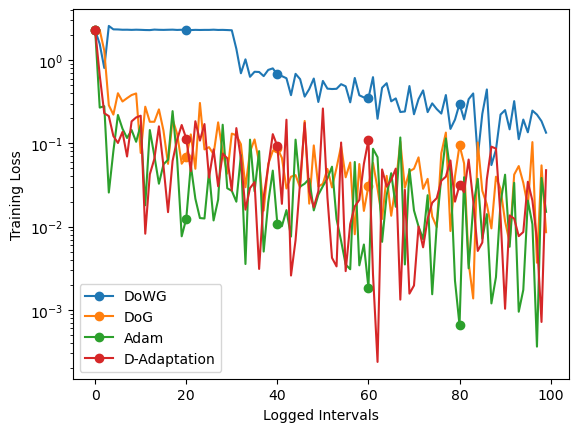

In [63]:
import matplotlib.pyplot as plt

def plot_training_losses(train_losses, alg_names, marker_interval=20):
    for (train_loss, alg_name) in zip(train_losses, alg_names):
        plt.plot(train_loss, label=alg_name, marker='o', markevery=marker_interval)
    plt.xlabel('Logged Intervals')
    plt.ylabel('Training Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

plot_training_losses([train_losses_dowg, train_losses_dog, train_losses_adam, train_losses_dadaptation], ["DoWG", "DoG", "Adam", "D-Adaptation"], 20)

In [31]:
print(torch.__version__)

2.0.1
